In [1]:
using Pkg

In [2]:
Pkg.activate("../")

  Activating project at `~/Julia_learning_repo/Yao_QC_learning/LS_EDF_QC`


In [3]:
using Yao

In [4]:
using LinearAlgebra

In [6]:
using Plots

In [7]:
gr; gr()

Plots.GRBackend()

# Quantum Circuit Born Machine

Let's implement a quantum circuit born machine described in [Jin-Guo Liu, Lei Wang](https://arxiv.org/abs/1804.04168)

## Training Target

we will ask the variational circuit to learn the most basic distribution: a guassian distribution. It is defined as follows:

$$ f(x\vert \mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

In [8]:
function gausian_pdf(x, μ::Real, σ::Real)
    pl = @. 1/sqrt(2π * σ^2) * exp(-(x - μ)^2 / (2 * σ^2))
    pl / sum(pl)
end

gausian_pdf (generic function with 1 method)

In [9]:
pg = gausian_pdf(1:1<<6, 1<<5-0.5, 1<<4);

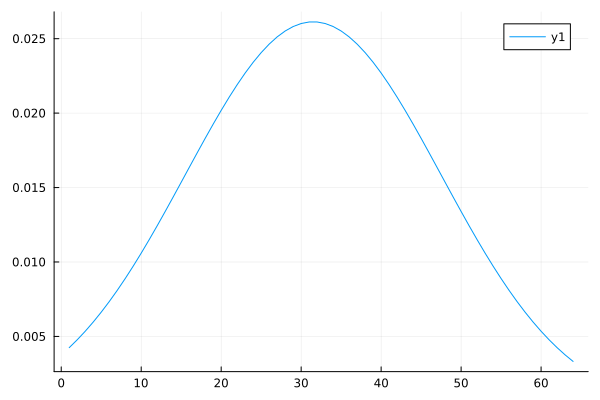

In [10]:
plot(pg)

## Create the Circuit

A quantum circuit born machine looks like the following:

![](https://docs.yaoquantum.org/dev/generated/examples/6.quantum-circuit-born-machine/assets/differentiable.png)

It is composited by two different layers: **rotation layer** and **entangler layer**.

## Rotation Layer

In [11]:
chain(Rz(0.0),Rz(0.0),Rz(0.0))

nqubits: 1
chain
├─ rot(Z, 0.0)
├─ rot(Z, 0.0)
└─ rot(Z, 0.0)

Nice, we can eather repeat this untill have our first layer and do this again...

![](https://media4.giphy.com/media/bWM2eWYfN3r20/giphy.gif?cid=790b7611b1e0eaf667048c7d1c02467e58a0bed16a9382fb&rid=giphy.gif&ct=g)

or we can create a function to handle this

In [13]:
layer(nbit::Int, x::Symbol) = layer(nbit, Val(x))
layer(nbit::Int, ::Val{:first}) = chain(nbit, put(i=> chain(Rx(0), Rz(0))) for i = 1:nbit)

layer (generic function with 2 methods)

Here a really nice feature from julia called [multiple dispatch](https://docs.julialang.org/en/v1/manual/methods/)

![](https://i.imgur.com/RCgNfp1.png)

We do not need to feed the first n parameter into put here. All factory methods can be lazy evaluate the first arguements, which is the number of qubits. It will return a lambda function that requires a single interger input. The instance of desired block will only be constructed until all the information is filled. When you filled all the information in somewhere of the declaration, 幺 will be able to infer the others. We will now define the rest of rotation layers

In [15]:
layer(nbit::Int, ::Val{:last}) = chain(nbit, put(i=>chain(Rz(0), Rx(0))) for i = 1:nbit)
layer(nbit::Int, ::Val{:mid}) = chain(nbit, put(i=>chain(Rz(0), Rx(0), Rz(0))) for i = 1:nbit);

# Entangler

Another component of quantum circuit born machine are several CNOT operators applied on different qubits.


In [16]:
entangler(pairs) = chain(control(ctrl, target=>X) for (ctrl, target) in pairs)

entangler (generic function with 1 method)

We can then define such a born machine:

In [17]:
function build_circuit(n, nlayers, pairs)
    circuit = chain(n)
    push!(circuit, layer(n, :first))
    for i in 2:nlayers
        push!(circuit, cache(entangler(pairs)))
        push!(circuit, layer(n, :mid))
    end
    push!(circuit, cache(entangler(pairs)))
    push!(circuit, layer(n, :last))
    return circuit
end

build_circuit (generic function with 1 method)

In [18]:
build_circuit(4, 1, [1=>2, 2=>3, 3=>4])

nqubits: 4
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  ├─ put on (2)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  ├─ put on (3)
│  │  └─ chain
│  │     ├─ rot(X, 0.0)
│  │     └─ rot(Z, 0.0)
│  └─ put on (4)
│     └─ chain
│        ├─ rot(X, 0.0)
│        └─ rot(Z, 0.0)
├─ [cached] chain
│     ├─ control(1)
│     │  └─ (2,) X
│     ├─ control(2)
│     │  └─ (3,) X
│     └─ control(3)
│        └─ (4,) X
└─ chain
   ├─ put on (1)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   ├─ put on (2)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   ├─ put on (3)
   │  └─ chain
   │     ├─ rot(Z, 0.0)
   │     └─ rot(X, 0.0)
   └─ put on (4)
      └─ chain
         ├─ rot(Z, 0.0)
         └─ rot(X, 0.0)


## MMD Loss & Gradients

The MMD (squared maximum mean discrepancy) loss is describe below:

$$ \mathcal{L} = \left\vert \sum_{x} p\theta(x)\phi(x) - \sum_{x}\pi(x)\phi(x)\right\vert^2$$

$$= \langle K(x,y)\rangle_{x\sim p_\theta, y\sim p_\theta} - 2 \langle K(x,y)\rangle_{x\sim p_\theta, y\sim \pi} + \langle K(x,y)\rangle_{x\sim \pi, y\sim \pi}$$

$K(x,y)$ is a gausian kernel

In [19]:
struct RBFKernel
    σ::Float64
    m::Matrix{Float64}
end

function RBFKernel(σ::Float64, space)
    dx2 = (space .- space').^2
    return RBFKernel(σ, exp.(-1/2σ * dx2))
end

kexpect(κ::RBFKernel, x, y) = x' * κ.m * y

kexpect (generic function with 1 method)

There are two different way to define the loss:

In simulation we can use the probability distribution of the state directly

In [20]:
get_prob(qcbm) = probs(zero_state(nqubits(qcbm)) |> qcbm)

function loss(κ, c, target)
    p = get_prob(c) - target
    return kexpect(κ, p, p)
end

loss (generic function with 1 method)

Or if we want to simulate the whole process with measurement (which is entirely physical), we should define the loss with measurement results, for convenience we directly use the simulated results as our loss

## Gradients

the gradient of MMD loss is

$$ \frac{\partial \mathcal{L}}{\partial \theta^{i}_{l}} = \langle K(x,y)\rangle_{x\sim p_+\theta, y\sim p_\theta} - \langle K(x,y)\rangle_{x\sim -p_\theta, y\sim p_\theta} - \langle K(x,y)\rangle_{x\sim +p_\theta, y\sim \pi} + \langle K(x,y)\rangle_{x\sim -p_\theta, y\sim \pi}$$

In [21]:
function gradient(qcbm, κ, ptrain)
    n = nqubits(qcbm)
    prob = get_prob(qcbm)
    grad = zeros(Float64, nparameters(qcbm))

    count = 1
    for k in 1:2:length(qcbm), each_line in qcbm[k], gate in content(each_line)
        dispatch!(+, gate, π/2)
        prob_pos = probs(zero_state(n) |> qcbm)

        dispatch!(-, gate, π)
        prob_neg = probs(zero_state(n) |> qcbm)

        dispatch!(+, gate, π/2) # set back

        grad_pos = kexpect(κ, prob, prob_pos) - kexpect(κ, prob, prob_neg)
        grad_neg = kexpect(κ, ptrain, prob_pos) - kexpect(κ, ptrain, prob_neg)
        grad[count] = grad_pos - grad_neg
        count += 1
    end
    return grad
end

gradient (generic function with 1 method)

Now let's setup the training

In [23]:
import Optimisers
qcbm = build_circuit(6, 10, [1=>2, 3=>4, 5=>6, 2=>3, 4=>5, 6=>1])
dispatch!(qcbm, :random) # initialize the parameters

κ = RBFKernel(0.25, 0:2^6-1)
pg = gausian_pdf(1:1<<6, 1<<5-0.5, 1<<4);
opt = Optimisers.setup(Optimisers.ADAM(0.01), parameters(qcbm));

function train(qcbm, κ, opt, target)
    history = Float64[]
    for _ in 1:100
        push!(history, loss(κ, qcbm, target))
        ps = parameters(qcbm)
        Optimisers.update!(opt, ps, gradient(qcbm, κ, target))
        dispatch!(qcbm, ps)
    end
    return history
end

history = train(qcbm, κ, opt, pg)
trained_pg = probs(zero_state(nqubits(qcbm)) |> qcbm)

64-element Vector{Float64}:
 0.004254831151527124
 0.004925427249403051
 0.005501745451677942
 0.005948243021254542
 0.006577452948653144
 0.007582726062096869
 0.008055082178208784
 0.008774511805468245
 0.009634960258191785
 0.010503479615428132
 0.011461635945751487
 0.01236920487266217
 0.0135381503568998
 ⋮
 0.010715206690903199
 0.00966816002894425
 0.008931365985264695
 0.00812443887491652
 0.00713852379485484
 0.006775937113593863
 0.005989034019029712
 0.005300191307338216
 0.00491013853041109
 0.004357671214419743
 0.003778903979967644
 0.0034466164094409286

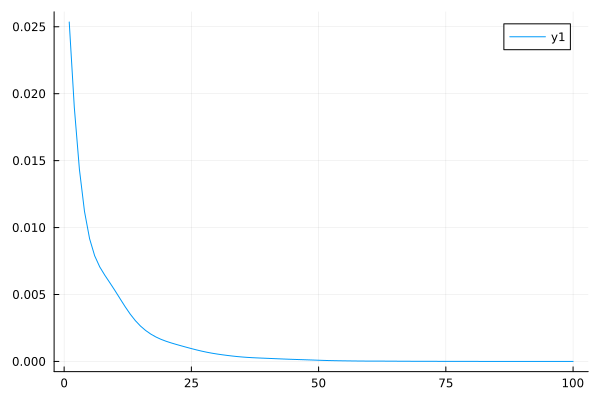

In [24]:
title!("training history")
xlabel!("steps"); ylabel!("loss")
plot(history)

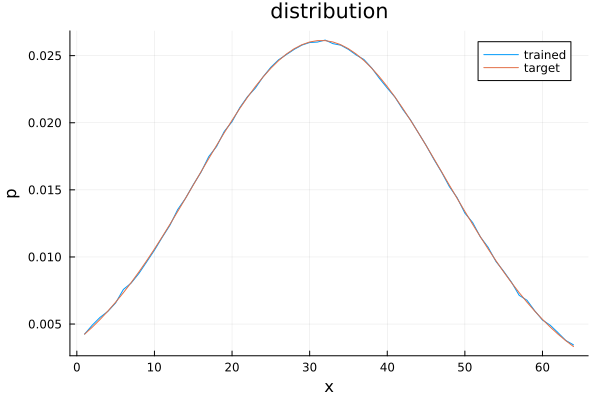

In [25]:
fig2 = plot(1:1<<6, trained_pg; label="trained")
plot!(fig2, 1:1<<6, pg; label="target")
title!("distribution")
xlabel!("x"); ylabel!("p")